# Multi-Scanner simulation with the Velodyne® VLP-16 ("Puck")

Notebook: Lukas Winiwarter, 2022

In this demo, we demonstrate how a scanner with multiple scanlines, such as the Velodyne® VLP-16, can be configured in HELIOS++. The demo contains two surveys, one for a static simulation (scanner at a single location) and one for a dynamic simulation (scanner moving between waypoints).

In [1]:
import sys, os
from pathlib import Path
from IPython.display import Code

current_folder = globals()["_dh"][0]
helios_path = str(Path(current_folder).parent)
sys.path.append(helios_path)  # add helios-plusplus directory to PATH
import pyhelios

from pyhelios.util.xmldisplayer import display_xml, find_playback_dir

## Scanner

As the scanner is the main component in this demo, we investigate the **scanner** XML file `tls_scanners.xml`. Here, we find a predefined *Velodyne VLP-16*. Other scanners, such as the *Velodyne Puck LITE*, or the *Ouster OS2* can be implemented in similar ways.

In [2]:
os.chdir(helios_path)
Code(display_xml(r'data\scanners_tls.xml', 'vlp16'))

<scanner id="vlp16" accuracy_m="0.03" beamDivergence_rad="0.0007" name="Velodyne VLP-16" optics="rotating" pulseFreqs_Hz="18750" pulseLength_ns="4" rangeMin_m="0.0100" rangeMax_m="100" scanAngleMax_deg="1" scanAngleEffectiveMax_deg="1" scanFreqMin_Hz="0" scanFreqMax_Hz="0" wavelength_nm="532" headRotatePerSecMax_deg="7200">
				
		<FWFSettings beamSampleQuality="1" />	
		<channels>
			<channel id="0">
				<beamOrigin x="0" y="0" z="0">				
					<rot axis="x" angle_deg="-15" />					
				</beamOrigin>
			</channel>
			<channel id="1">
				<beamOrigin x="0" y="0" z="0">
					<rot axis="x" angle_deg="1" />					
				</beamOrigin>
			</channel>
			<channel id="2">
				<beamOrigin x="0" y="0" z="0">
					<rot axis="x" angle_deg="-13" />					
				</beamOrigin>
			</channel>
			<channel id="3">
				<beamOrigin x="0" y="0" z="0">
					<rot axis="x" angle_deg="3" />					
				</beamOrigin>
			</channel>
			<channel id="4">
				<beamOrigin x="0" y="0" z="0">
					<rot axis="x" angle_deg="-11" />					
				</beamOrigin>
			</channel>
			<channel id="5">
				<beamOrigin x="0" y="0" z="0">
					<rot axis="x" angle_deg="5" />					
				</beamOrigin>
			</channel>
			<channel id="6">
				<beamOrigin x="0" y="0" z="0">
					<rot axis="x" angle_deg="-9" />					
				</beamOrigin>
			</channel>
			<channel id="7">
				<beamOrigin x="0" y="0" z="0">
					<rot axis="x" angle_deg="7" />					
				</beamOrigin>
			</channel>
			<channel id="8">
				<beamOrigin x="0" y="0" z="0">
					<rot axis="x" angle_deg="-7" />					
				</beamOrigin>
			</channel>
			<channel id="9">
				<beamOrigin x="0" y="0" z="0">
					<rot axis="x" angle_deg="9" />					
				</beamOrigin>
			</channel>
			<channel id="10">
				<beamOrigin x="0" y="0" z="0">
					<rot axis="x" angle_deg="-5" />					
				</beamOrigin>
			</channel>
			<channel id="11">
				<beamOrigin x="0" y="0" z="0">
					<rot axis="x" angle_deg="11" />					
				</beamOrigin>
			</channel>
			<channel id="12">
				<beamOrigin x="0" y="0" z="0">
					<rot axis="x" angle_deg="-3" />					
				</beamOrigin>
			</channel>
			<channel id="13">
				<beamOrigin x="0" y="0" z="0">
					<rot axis="x" angle_deg="13" />					
				</beamOrigin>
			</channel>
			<channel id="14">
				<beamOrigin x="0" y="0" z="0">
					<rot axis="x" angle_deg="-1" />					
				</beamOrigin>
			</channel>
			<channel id="15">
				<beamOrigin x="0" y="0" z="0">
					<rot axis="x" angle_deg="15" />					
				</beamOrigin>
			</channel>
		</channels>

	</scanner>

The scanner is defined with `rotating` optics, but the values for `scanFreqMin_Hz` and `scanFreqMax_Hz` (both `"0"`) show that this feature is not used in this implementation. Additionaly, the `scanAngleMax_deg` is set to a value of `1`. Subsequently, 16 `channel`s are defined, each with their individual rotations. As the scan plane is not used (default would be the y/z-Plane, see [the wiki](https://github.com/3dgeo-heidelberg/helios/wiki/Scanners)) and only a single direction per pulse is given, a simple rotation upwards or downwards about the `x` axis is sufficient. The values for the angles are taken from the [user manual of the VLP-16](https://velodynelidar.com/wp-content/uploads/2019/12/63-9243-Rev-E-VLP-16-User-Manual.pdf) (pages 54-55).

The `pulseFreq_hz` in the `<scannerSettings >` is coming from the max. measurement rate of the *VLP-16* (300,000 pts/sec). The `headRotatePerSecMax_deg` value corresponds to what Velodyne refers to as *scan frequency* - this is not to be confused with the *within-scan line* `scanFreq_hz` we use for e.g. *RIEGL*-type TLS sensors. The user manual gives a value of `1200 rpm` as a maximum rotation speed of the motor, equivalent to 20 rotations per seconds (20 Hz *scan frequency*), or a rotation speed `headRotatePerSecMax_deg` of `7200` (20 * 360deg). 


Let us now use a simple scene (just containing a cube with 100 m side length, centered around the origin) to carry out two surveys:

## Static survey

In [3]:
Code(display_xml(r'data\surveys\demo\box_survey_static_puck.xml'))

<document>
    <scannerSettings id="scaset" active="true" pulseFreq_hz="18750" scanFreq_hz="0" />
    <survey name="box_puck_static" scene="data/scenes/demo/box_scene.xml#box_scene" platform="data/platforms.xml#tripod" scanner="data/scanners_tls.xml#vlp16">
		<leg>
            <platformSettings x="0" y="0" z="0" />
			<scannerSettings template="scaset" headRotatePerSec_deg="3600" headRotateStart_deg="0" headRotateStop_deg="3600" /> 
        </leg>
    </survey>
</document>

Here, we note two things:
1) the value of `headRotatePerSec_deg`, which here corresponds to 10 rotations per second, or 600 rotations per minute. The user manual explains that values between 300 and 1200 rpm, in increments of 60 rpm, are permissible.

2) the range between `headRotateStart_deg` and `headRotateStop_deg`. Combined with the rotation speed, this gives the sensor's integration time. In this example, 10 full rotations (10 * 360 deg) are carried out, which takes (at a rotation speed of 10 rotations per second or 3600 deg per second) one second. We are now ready to 

## Execute the simulation


In [4]:
!"run/helios.exe" data/surveys/demo/box_survey_static_puck.xml

HELIOS++ VERSION 1.1.1

CWD: "C:\Users\Lukas\Documents\Projects\helios\repo"
seed: AUTO
surveyPath: "data/surveys/demo/box_survey_static_puck.xml"
assetsPath: "assets/"
outputPath: "output/"
writeWaveform: 0
calcEchowidth: 0
fullWaveNoise: 0
splitByChannel: 0
parallelization: 1
njobs: 0
chunkSize: 32
warehouseFactor: 4
platformNoiseDisabled: 0
legNoiseDisabled: 0
rebuildScene: 0
lasOutput: 0
las10: 0
fixedIncidenceAngle: 0
gpsStartTime: 
kdtType: 4
kdtJobs: 0
kdtGeomJobs: 0
sahLossNodes: 32

xmlDocFilename: box_survey_static_puck.xml
xmlDocFilePath: data/surveys/demo
xmlDocFilename: scanners_tls.xml
xmlDocFilePath: data
Using default value for attribute 'averagePower_w' : 4
Using default value for attribute 'beamQualityFactor' : 1
Using default value for attribute 'opticalEfficiency' : 0.99
Using default value for attribute 'receiverDiameter_m' : 0.15
Using default value for attribute 'atmosphericVisibility_km' : 23
Using default value for attribute 'binSize_ns' : 0.25
Using default va

## Results

Now let's find the output files and display a 3D plot for all points recorded in the first 1/10th second (one rotation). You can see how the 'zero' location of the scanner is towards the positive Y-axis.

Loading points from C:\Users\Lukas\Documents\Projects\helios\repo\output\box_puck_static\2023-01-12_14-15-15


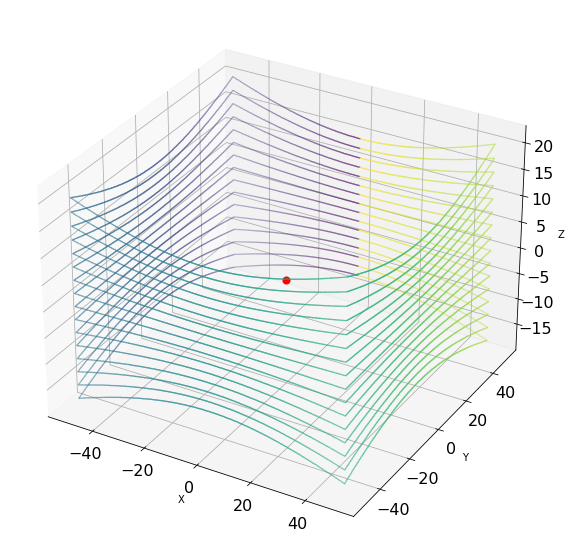

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

output_path = find_playback_dir(r"data/surveys/demo/box_survey_static_puck.xml")

print("Loading points from", output_path)
SP1 = pd.read_csv(Path(output_path) / 'leg000_points.xyz', 
                  names="X Y Z intensity echoWidth returnNumber numberOfReturns fullwaveIndex hitObjectId class gpsTime".split(' '),
                  delimiter=' ')

SP_filtered = SP1[SP1['gpsTime'] <= min(SP1['gpsTime']) + 0.1]  # select all points recorded in the first 1/10 second

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(SP_filtered['X'], SP_filtered['Y'], SP_filtered['Z'], s=0.1, c=SP_filtered['gpsTime']) 
ax.scatter([0], [0], [0], s=50, c='red') 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.tick_params(labelsize=16)
plt.show()


## Dynamic survey

We now want to simulate a moving scanner (e.g. a driving car). We use the same scene as before, but move the scanner from `(-40, 0, 0)` to `(40, 0, 0)` over a course of 10 seconds (`8 m/s`). Note how we have to adapt the `headRotateStop_deg` to `36000` to allow for 10 seconds of operation (at a rotation of `10` Hz) before the survey exits.

In [6]:
Code(display_xml(r'data\surveys\demo\box_survey_moving_puck.xml'))

<document>
    <scannerSettings id="scaset" active="true" pulseFreq_hz="18750" scanFreq_hz="0" />
    <survey name="box_puck_moving" scene="data/scenes/demo/box_scene.xml#box_scene" platform="data/platforms.xml#simple_linearpath" scanner="data/scanners_tls.xml#vlp16">
		<leg>
            <platformSettings x="-40" y="0" z="0" movePerSec_m="8" /> 
			<scannerSettings template="scaset" trajectoryTimeInterval_s="0.01" headRotatePerSec_deg="3600" headRotateStart_deg="0" headRotateStop_deg="36000" /> 
        </leg>
			<leg>
            <platformSettings x="40" y="0" z="0" />
			<scannerSettings active="false" />
        </leg>
    </survey>
</document>

## Execute the simulation


In [7]:
!"run/helios.exe" data/surveys/demo/box_survey_moving_puck.xml

HELIOS++ VERSION 1.1.1

CWD: "C:\Users\Lukas\Documents\Projects\helios\repo"
seed: AUTO
surveyPath: "data/surveys/demo/box_survey_moving_puck.xml"
assetsPath: "assets/"
outputPath: "output/"
writeWaveform: 0
calcEchowidth: 0
fullWaveNoise: 0
splitByChannel: 0
parallelization: 1
njobs: 0
chunkSize: 32
warehouseFactor: 4
platformNoiseDisabled: 0
legNoiseDisabled: 0
rebuildScene: 0
lasOutput: 0
las10: 0
fixedIncidenceAngle: 0
gpsStartTime: 
kdtType: 4
kdtJobs: 0
kdtGeomJobs: 0
sahLossNodes: 32

xmlDocFilename: box_survey_moving_puck.xml
xmlDocFilePath: data/surveys/demo
xmlDocFilename: scanners_tls.xml
xmlDocFilePath: data
Using default value for attribute 'averagePower_w' : 4
Using default value for attribute 'beamQualityFactor' : 1
Using default value for attribute 'opticalEfficiency' : 0.99
Using default value for attribute 'receiverDiameter_m' : 0.15
Using default value for attribute 'atmosphericVisibility_km' : 23
Using default value for attribute 'binSize_ns' : 0.25
Using default va

## Results

Now let's find the output files and display a 3D plot for all points recorded in the first 1/10th second (one rotation). In a second plot, we plot the points recorded in the last 1/10th second (last rotation).

Loading points from C:\Users\Lukas\Documents\Projects\helios\repo\output\box_puck_moving\2023-01-12_14-15-21


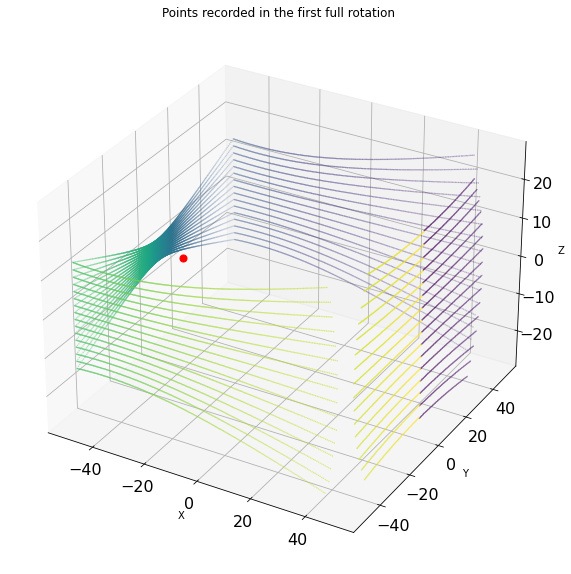

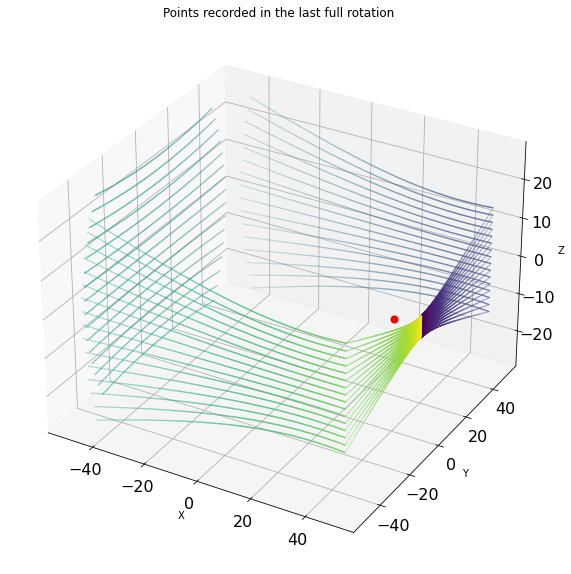

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

output_path = find_playback_dir(r"data/surveys/demo/box_survey_moving_puck.xml")

print("Loading points from", output_path)
SP1 = pd.read_csv(Path(output_path) / 'leg000_points.xyz', 
                  names="X Y Z intensity echoWidth returnNumber numberOfReturns fullwaveIndex hitObjectId class gpsTime".split(' '),
                  delimiter=' ')

for fun in (min, max):

    SP_filtered = SP1[abs(SP1['gpsTime']- fun(SP1['gpsTime'])) <= 0.1]  # select all points recorded in the first/last 1/10 second

    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(projection='3d')

    ax.scatter(SP_filtered['X'], SP_filtered['Y'], SP_filtered['Z'], s=0.1, c=SP_filtered['gpsTime']) 
    ax.scatter([-40 if fun is min else 40], [0], [0], s=50, c='red') 

    ax.tick_params(labelsize=16)
    plt.title("Points recorded in the "+
             ("first " if fun is min else "last ")+
             "full rotation")
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

In contrast to the static case, the 'zero' point now appears towards the positive x-Axis! What happened? The `linearpath` platform oriented the sensor such that the default axis (which is `y` for the scanners) is pointing *forward* in the direction of movement. As the platform (`simple_linearpath`) does not provide any additional rotations (e.g. in contrast to the `sr22` airborne platform), the scanner faces towards the direction of movement at the beginning of the scan.

The gaps in the 'far' corners are due to the maximum range of the scanner, given as 100 m.